# ATLAS: Enhancing Language Models through External Document Retrieval




ATLAS is a retrieval-augmented language model that significantly improves accuracy, particularly in question-answering tasks, by retrieving relevant external documents. It employs a dual-encoder retriever to identify the top-K relevant documents from large text corpora, ensuring that the model has access to pertinent information. A Fusion-in-Decoder model integrates both query and document information, allowing for the generation of accurate responses while reducing reliance on memorization. Additionally, the document index can be updated without retraining the model, ensuring it remains current and effective for knowledge-intensive tasks.



## Key Features of ATLAS



- **Dual-Encoder Retriever**: Utilizes a dual-encoder architecture to efficiently retrieve the most relevant documents from extensive text corpora, such as Wikipedia and Common Crawl.

- **Fusion-in-Decoder Model**: Integrates query and document information within the decoding process, enhancing the model's ability to generate accurate and contextually relevant responses.

- **Dynamic Document Indexing**: Allows for updates to the document index without requiring retraining of the language model, ensuring that the model can adapt to new information quickly.

- **Reduction of Memorization Reliance**: By leveraging external documents, ATLAS reduces the need for the model to memorize vast amounts of information, thereby improving efficiency and accuracy.



## How ATLAS Works



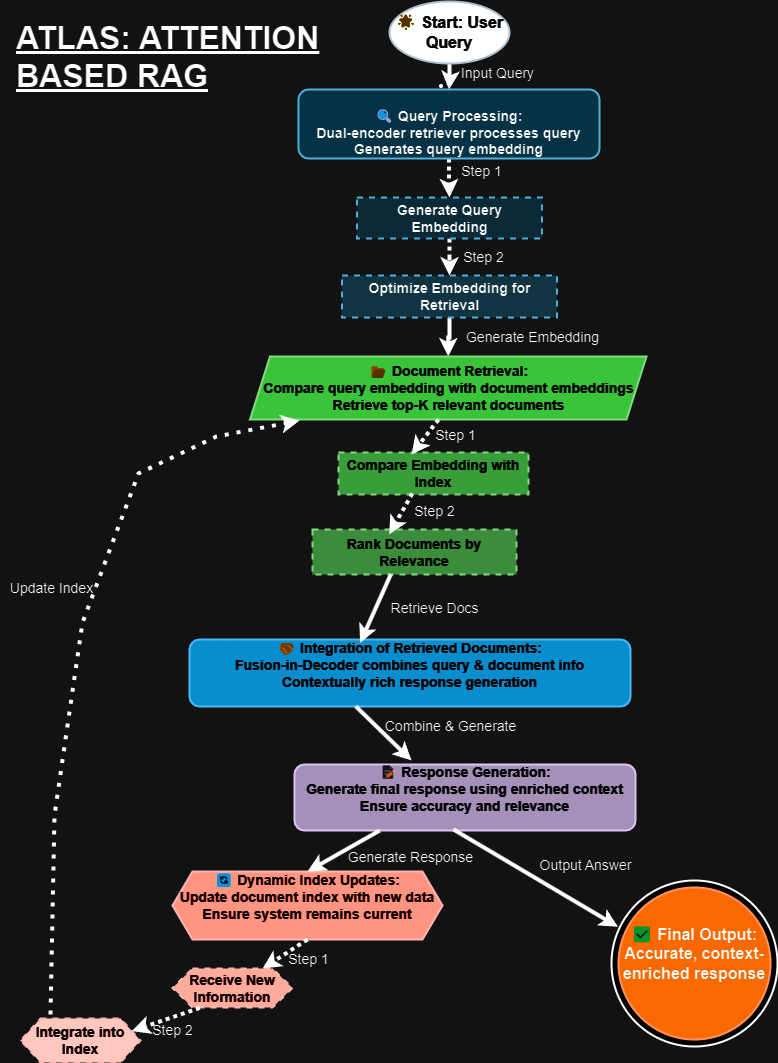

1. **Query Processing**: When a user submits a query, ATLAS first processes it through its dual-encoder retriever to generate an embedding representation of the query.

2. **Document Retrieval**:
   - The retriever compares the query embedding against stored document embeddings to identify the top-K most relevant documents.
   - This process leverages efficient similarity search techniques to quickly locate pertinent information.

3. **Integration of Retrieved Documents**:
   - The Fusion-in-Decoder model combines both the original query and the retrieved document information.
   - This integration allows for contextually rich responses that are informed by external knowledge.

4. **Response Generation**: The language model generates a final response based on both the query and the integrated document information, ensuring accuracy and relevance.

5. **Dynamic Index Updates**: The document index can be updated as new information becomes available, allowing ATLAS to remain current without needing extensive retraining sessions.



In [ ]:
!pip install pypdf2 groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
import requests
from sklearn.metrics.pairwise import cosine_similarity
import torch
from PyPDF2 import PdfReader
from groq import Groq

In [ ]:
# Step 0: Initialize the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 1: Download and process the PDF document
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # BERT paper
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 2: Define the query and create an evaluation dataset
query = "What is Transformer encoder?"
evaluation_dataset = [
    {"query": query, "expected_output": "Information about Transformer encoders in NLP"}
]

In [ ]:
# Step 3: Chunk the document for processing (simulating document retrieval)
chunks = [text[i:i + 1000] for i in range(0, len(text), 1000)]  # Divide document into manageable chunks

In [ ]:
# Step 4: Retrieve the top-K most relevant document chunks based on a simple similarity metric
def simple_cosine_similarity(query, chunk):
    # Convert query and chunk to sets of tokens
    query_tokens = set(query.split())
    chunk_tokens = set(chunk.split())

    # Find the intersection of query tokens and chunk tokens
    intersection = query_tokens & chunk_tokens  # This gives the common tokens

    # Create vectors based on the intersection size (representing similarity)
    query_vector = torch.tensor([len(intersection)]).float()
    chunk_vector = torch.tensor([len(intersection)]).float()

    # Use cosine similarity to compare the query and chunk vectors
    return cosine_similarity(query_vector.unsqueeze(0), chunk_vector.unsqueeze(0)).flatten()

In [ ]:
# Step 5: Document retrieval - retrieve the most relevant chunks using cosine similarity
chunk_embeddings = [simple_cosine_similarity(query, chunk) for chunk in chunks]
top_k = 5  # Retrieve the top 5 most relevant chunks
retrieved_chunk_indices = sorted(range(len(chunk_embeddings)), key=lambda i: chunk_embeddings[i], reverse=True)[:top_k]
retrieved_chunks = [chunks[i] for i in retrieved_chunk_indices]

In [ ]:
# Step 6: Fusion-in-Decoder Approach (Integration of Retrieved Chunks)
# Instead of BERT embeddings, we use simple document information for generation
print(f"Top retrieved chunks for query '{query}':\n")
for idx, chunk in enumerate(retrieved_chunks, start=1):
    print(f"Chunk {idx}: {chunk[:200]}...\n")  # Display first 200 characters of each chunk

Top retrieved chunks for query 'What is Transformer encoder?':

Chunk 1: BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding
Jacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova
Google AI Language
fjacobdevlin,mingweichang,kentonl,kristout...

Chunk 2:  are two existing strategies for apply-
ing pre-trained language representations to down-
stream tasks: feature-based andﬁne-tuning . The
feature-based approach, such as ELMo (Peters
et al., 2018a), u...

Chunk 3: r
example, in OpenAI GPT, the authors use a left-to-
right architecture, where every token can only at-
tend to previous tokens in the self-attention layers
of the Transformer (Vaswani et al., 2017). ...

Chunk 4: 
right language model pre-training, the MLM ob-
jective enables the representation to fuse the left
and the right context, which allows us to pre-
train a deep bidirectional Transformer. In addi-
tion...

Chunk 5: -art performance on a large suite
of sentence-level andtoken-level task

In [ ]:
# Step 7: Use Groq for generating a response based on retrieved documents
module_results = []
for chunk in retrieved_chunks:
    try:
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an advanced assistant that evaluates information retrieval pipelines."},
                {"role": "user", "content": f"Based on the query '{query}' and the retrieved passage:\n{chunk}\nProvide a concise explanation."},
            ],
            model="llama3-8b-8192",
        )
        answer = response.choices[0].message.content
        module_results.append({"chunk": chunk[:200], "answer": answer})  # Store chunk and answer
        print(f"Generated answer: {answer}")
    except Exception as e:
        print(f"Error generating answer: {e}")

Generated answer: Based on the retrieved passage, the Transformer encoder is a component of the BERT (Bidirectional Encoder Representations from Transformers) language representation model. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers.
Generated answer: The retrieved passage appears to be a research article discussing strategies for applying pre-trained language representations to downstream tasks. The passage mentions two existing strategies: feature-based and fine-tuning approaches. It also introduces the concept of unidirectional language models as a limitation, implying that it has not yet discussed the Transformer encoder specifically. Therefore, based on the provided passage, it is not possible to provide a concise explanation of what a Transformer encoder is.
Generated answer: Based on the retrieved passage, the Transformer encoder refers to a type of architecture used in n

In [ ]:
# Step 8: Response Generation and Final Answer
best_result = max(module_results, key=lambda x: len(x["answer"]))  # Example: Select result with the longest answer
print("\nBest result based on module evaluation:")
print(f"Chunk: {best_result['chunk']}\nAnswer: {best_result['answer']}")


Best result based on module evaluation:
Chunk: r
example, in OpenAI GPT, the authors use a left-to-
right architecture, where every token can only at-
tend to previous tokens in the self-attention layers
of the Transformer (Vaswani et al., 2017). 
Answer: Based on the retrieved passage, the Transformer encoder refers to a type of architecture used in natural language processing, particularly in the BERT (Bidirectional Encoder Representations from Transformers) model. Unlike the left-to-right architecture used in other models, such as OpenAI GPT, the Transformer encoder allows for bidirectional context incorporation, enabling the model to attend to both previous and subsequent tokens in the input sequence. This bidirectional arrangement is achieved through the use of a "masked language model" pre-training objective, which randomly masks some input tokens and trains the model to predict the original vocabulary id of the masked word based on its context. This allows the model to capture 

In [ ]:
# Step 9: Final Output
final_output = best_result["answer"]
print("\n--- Final Answer ---\n")
print(final_output)


--- Final Answer ---

Based on the retrieved passage, the Transformer encoder refers to a type of architecture used in natural language processing, particularly in the BERT (Bidirectional Encoder Representations from Transformers) model. Unlike the left-to-right architecture used in other models, such as OpenAI GPT, the Transformer encoder allows for bidirectional context incorporation, enabling the model to attend to both previous and subsequent tokens in the input sequence. This bidirectional arrangement is achieved through the use of a "masked language model" pre-training objective, which randomly masks some input tokens and trains the model to predict the original vocabulary id of the masked word based on its context. This allows the model to capture more nuanced and context-dependent information, which can be beneficial for tasks such as question answering.


## Code Explanation


## 1. Import Libraries

The script begins by importing necessary libraries:
- **requests**: Used for making HTTP requests to download the PDF.
- **cosine_similarity**: From the `sklearn` library, this function is used to compute similarity between vectors.
- **torch**: A library for tensor operations, which is necessary for calculating similarity.
- **PdfReader**: From the `PyPDF2` library, this is used to read and extract text from PDF files.
- **Groq**: A client library for interacting with the Groq language model.

## 2. Initialize the Groq Client

A Groq client is initialized with an API key that allows the script to access Groq's services for generating responses.

## 3. Download PDF Document

The script downloads a PDF from a specified URL (in this case, a paper on BERT) and saves it locally. This step ensures that the document is available for text extraction.

## 4. Extract Text from PDF

Using `PdfReader`, the script reads through each page of the downloaded PDF and extracts its text. The extracted text is concatenated into a single string for further processing.

## 5. Define Query

A sample query is defined to evaluate against the extracted text. This query serves as the basis for retrieving relevant information from the document.

## 6. Chunk the Document

The extracted text is divided into smaller chunks (of 1000 characters each) to facilitate easier processing and retrieval of relevant information.

## 7. Cosine Similarity Function

A function is defined to calculate cosine similarity between the query and each document chunk. This function works by:
- Converting both the query and chunk into sets of tokens (words).
- Finding the intersection of these token sets to determine common words.
- Creating vectors based on the size of this intersection, which represent similarity.

## 8. Retrieve Relevant Chunks

The script computes similarity scores for each chunk relative to the query and retrieves the top K (5) most relevant chunks based on these scores. This step focuses on identifying which parts of the document are most pertinent to the user's query.

## 9. Display Retrieved Chunks

The top retrieved chunks related to the query are printed out, showing only the first 200 characters of each chunk for brevity.

## 10. Generate Responses Using Groq

For each retrieved chunk, the script generates responses using Groq's chat completion feature. It sends a prompt that includes both the user's query and the retrieved passage, asking for a concise explanation. The generated answers are stored for evaluation.

## 11. Select Best Result

After generating responses, the script selects the best answer based on specific criteria (in this case, length). This step ensures that the most informative response is chosen for presentation.

## 12. Final Output

Finally, the best generated answer is printed as the final output of the script. This answer represents a synthesized response based on both user input and relevant information extracted from the document.

## Applications of ATLAS



- **Open-Domain Question Answering**: Provides accurate answers by leveraging external knowledge effectively in various domains.

- **Knowledge Management Systems**: Enhances systems that require up-to-date information retrieval while ensuring accuracy in responses based on comprehensive data access.

- **Content Generation Tools**: Assists writers by generating context-rich narratives that draw from extensive knowledge bases without relying solely on memorized content.

- **Educational Platforms**: Supports learning applications by providing students with reliable information tailored to their queries with deeper contextual understanding.



## Advantages of ATLAS



- **Enhanced Accuracy in Responses**: By retrieving relevant documents, ATLAS can provide more accurate answers to user queries, particularly in complex question-answering scenarios.

- **Scalability**: The ability to update the document index dynamically allows ATLAS to scale effectively with new information without extensive retraining processes.

- **Improved Interpretability**: The integration of external knowledge provides a clearer rationale for responses, enhancing user trust in the model's outputs.

- **Efficiency in Task Performance**: The dual-encoder design allows for quick retrieval of relevant documents, improving response times in real-time applications.



## Limitations of ATLAS



- **Dependence on Document Quality**: The effectiveness of ATLAS is contingent on the quality and relevance of the retrieved documents; poor-quality sources can lead to inaccuracies in responses.

- **Complexity in Implementation**: Integrating a dual-encoder retriever with a language model may introduce complexity in system design and require careful management.

- **Resource Intensive**: The retrieval process may require significant computational resources, particularly when dealing with large datasets or extensive corpora.



## Conclusion



ATLAS represents a significant advancement in retrieval-augmented language models by effectively integrating external document retrieval into its architecture. This approach enhances response accuracy while reducing reliance on memorization, making it an efficient tool for various applications. As AI continues to evolve, frameworks like ATLAS will play an essential role in improving how language models interact with vast amounts of data and provide reliable information.



Having explored ATLAS, we will now move on to RETRO (Retrieval-Augmented Transformer).